In [9]:
#run with Python 3.11
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

Using device: cuda


In [11]:
#Hyperparams
batch_size = 128

## Data Preprocessing


In [12]:
def get_notes(load_existing = True):
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    if load_existing:
        print("loading existing notes")
        with open('data/notes', 'rb') as filepath:
            notes, durations = pickle.load(filepath)
            return notes, durations
    
    notes = []
    durations = []

    for file in glob.glob("midi_songs/**/*.mid", recursive=True):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                durations.append(element.duration.quarterLength)
                
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                durations.append(element.duration.quarterLength)

    with open('data/notes', 'wb') as filepath:
        pickle.dump((notes, durations), filepath)

    return notes, durations


#assemble training data in a readable format 
from preprocessing import prepare_sequences, encode_data


In [13]:
notes, durations = get_notes(load_existing=False) # set load_existing to False if you added new training data in midi_songs

# get amount of pitch names
n_vocab = len(set(notes))
d_vocab = len(set(durations))

network_input, network_output = prepare_sequences(notes, durations, n_vocab, d_vocab)

#build the dataset + dataloader
input_tensor = torch.tensor(network_input)
print("input tensor shape: ", input_tensor.shape)

output_tensor = torch.tensor(network_output)
print("output tensor shape: ", output_tensor.shape)

dataset = TensorDataset(input_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #1:36 w/ np

Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n01.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n02.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n03.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n04.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n05.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n06.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n07.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n08 op13 1mov ''Pathetique''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n08 op13 2mov ''Pathetique''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n08 op13 3mov ''Pathetique''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n09.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n10 1mov.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n10 2mov.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n10.mid
Parsing midi_songs\

c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Mondscheinsonate; der Gr\xe4fin Giulietta Guiccardi gewidmet'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n14 op27 1mov ''Moonlight''.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n14 op27 2mov ''Moonlight''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n14 op27 3mov ''Moonlight''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n15 ''Pastoral''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n15 2mov ''Pastoral''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n15 3mov ''Pastoral''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n16.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n17 ''Tempestat''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n18 ''The Hunt''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n19.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n20.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n21 1mov ''Waldstein''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n21 2mov ''Waldstein''.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n21 3mov ''Waldstein''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n22.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n23 op57 1mov ''Apassionata''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n23 op57 2mov ''Apassionata''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n23 op57 3mov ''Apassionata''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n24.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n25.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano sonata n26 ''Les Adieux''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n27.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n28.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n29 Op106 ''Hammerklavier''.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n30.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano Sonata n31 op110.mid
Parsing midi_songs\Beethoven\Piano Sonatas\Piano sonata n32 op111.mid
Parsing midi_songs\Bwv772-786 Two Part Inventions\Bwv772 Invention n01.mid
Parsing midi_songs\Bwv772-78

c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97\x97'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'  Piano \x96 r. h.  {51}'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=9, channel=None, data=b'  Piano \x96 l. h.  {51}'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Clementi\Etude n6.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'  Piano \x96 r. h. (voice #1)  {49}'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=9, channel=None, data=b'  Piano \x96 r. h. (voice #2)  {51}'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=10, channel=None, data=b'  Piano \x96 l. h. (voice #3)  {27}'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=11, channe

Parsing midi_songs\Clementi\Etude n8.mid
Parsing midi_songs\Clementi\Etude No. 6 in D major.mid
Parsing midi_songs\Clementi\Etude No. 8 in F major.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'L.H.\xf9'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Clementi\Gradus ad Parnassum No.1.mid
Parsing midi_songs\Clementi\Gradus ad Parnassum No.2.mid
Parsing midi_songs\Clementi\Gradus ad Parnassum No.9.mid
Parsing midi_songs\Clementi\Piano Sonata in C Duet.mid
Parsing midi_songs\Clementi\Sonata n5 op25 1mov.mid
Parsing midi_songs\Clementi\Sonata n5 op25 2mov.mid
Parsing midi_songs\Clementi\Sonata n5 op25 3mov.mid
Parsing midi_songs\Clementi\sonatina op36 n1 1mov.mid
Parsing midi_songs\Clementi\sonatina op36 n1 2mov.mid
Parsing midi_songs\Clementi\sonatina op36 n1 3mov.mid
Parsing midi_songs\Clementi\sonatina op36 n2 1mov.mid
Parsing midi_songs\Clementi\sonatina op36 n2 2mov.mid
Parsing midi_songs\Clementi\sonatina op36 n2 3mov.mid
Parsing midi_songs\Clementi\sonatina op36 n3 1mov.mid
Parsing midi_songs\Clementi\sonatina op36 n3 2mov.mid
Parsing midi_songs\Clementi\sonatina op36 n3 3mov.mid
Parsing midi_songs\Clementi\sonatina op36 n4 1mov.mid
Parsing midi_songs\Clementi\sonatina op36 n4 2mov.mid
Parsing midi_songs\Cleme

c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Alessandro Simonetto, \xa9 2004'>; getting generic Instrument
  warnings.warn(
c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'All rights reserved, \xa9 2002-04'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Clementi\Studio Gradus Ad Parnassum n16.mid
Parsing midi_songs\Clementi\Studio Gradus Ad Parnassum n17.mid
Parsing midi_songs\Clementi\Studio Gradus Ad Parnassum n26.mid


c:\Python311\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'All right reserved, \xa9 2002-04'>; getting generic Instrument
  warnings.warn(


Parsing midi_songs\Clementi\Studio Gradus Ad Parnassum n65.mid
input tensor shape:  torch.Size([380193, 100, 2])
output tensor shape:  torch.Size([380193, 2])


C:\Users\Archimedes Li\AppData\Local\Temp\ipykernel_13948\910838895.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(network_input)
C:\Users\Archimedes Li\AppData\Local\Temp\ipykernel_13948\910838895.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(network_output)


In [14]:
#view a single data shape
print(input_tensor[0].shape)
print(output_tensor[0].shape)

torch.Size([100, 2])
torch.Size([2])


## Model Architecture

In [15]:
from models import MusicLSTM, MusicLSTM2

def train(num_epochs, model, train_dataloader, loss_func, optimizer):
    losses = []
    total_steps = len(train_dataloader)

    for epoch in range(num_epochs):
        for batch, (sequence, next_note) in enumerate(train_dataloader):
            #apply one-hot encoding to sequence and next_note
            sequence = encode_data(sequence, n_vocab, d_vocab, device, type="input")
            next_note = encode_data(next_note, n_vocab, d_vocab, device, type="output")

            output = model(sequence)
            loss = loss_func(output, next_note)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1)%100 == 0:
                print(f"Epoch: {epoch+1}; Batch {batch+1} / {total_steps}; Loss: {loss.item():>4f}")
        print(f"Epoch: {epoch+1} complete; Loss: {loss.item():>4f}")
    return losses

## Training

In [17]:
#set input len to 1
model = MusicLSTM2(input_len=1, hidden_size=1024, num_note_classes=n_vocab, num_duration_classes = d_vocab, num_layers=2)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

losses = train(num_epochs=75, model=model, loss_func=loss_function, optimizer=optimizer, train_dataloader=dataloader)


Epoch: 1; Batch 100 / 2971; Loss: 7.981238
Epoch: 1; Batch 200 / 2971; Loss: 7.378975
Epoch: 1; Batch 300 / 2971; Loss: 7.262916
Epoch: 1; Batch 400 / 2971; Loss: 7.213468
Epoch: 1; Batch 500 / 2971; Loss: 7.291775
Epoch: 1; Batch 600 / 2971; Loss: 6.871525
Epoch: 1; Batch 700 / 2971; Loss: 7.171035
Epoch: 1; Batch 800 / 2971; Loss: 6.779399
Epoch: 1; Batch 900 / 2971; Loss: 7.038298
Epoch: 1; Batch 1000 / 2971; Loss: 6.897378
Epoch: 1; Batch 1100 / 2971; Loss: 6.938428
Epoch: 1; Batch 1200 / 2971; Loss: 6.729343
Epoch: 1; Batch 1300 / 2971; Loss: 6.749369
Epoch: 1; Batch 1400 / 2971; Loss: 6.960410
Epoch: 1; Batch 1500 / 2971; Loss: 6.872208
Epoch: 1; Batch 1600 / 2971; Loss: 6.567840
Epoch: 1; Batch 1700 / 2971; Loss: 6.625509
Epoch: 1; Batch 1800 / 2971; Loss: 6.492676
Epoch: 1; Batch 1900 / 2971; Loss: 6.767765
Epoch: 1; Batch 2000 / 2971; Loss: 6.620800
Epoch: 1; Batch 2100 / 2971; Loss: 6.435802
Epoch: 1; Batch 2200 / 2971; Loss: 6.274227
Epoch: 1; Batch 2300 / 2971; Loss: 6.7437

In [18]:
torch.save(model, "models/music_model.pt")

In [ ]:

#losses2 = train(num_epochs=50, model=model, loss_func=loss_function, optimizer=optimizer, train_dataloader=dataloader)


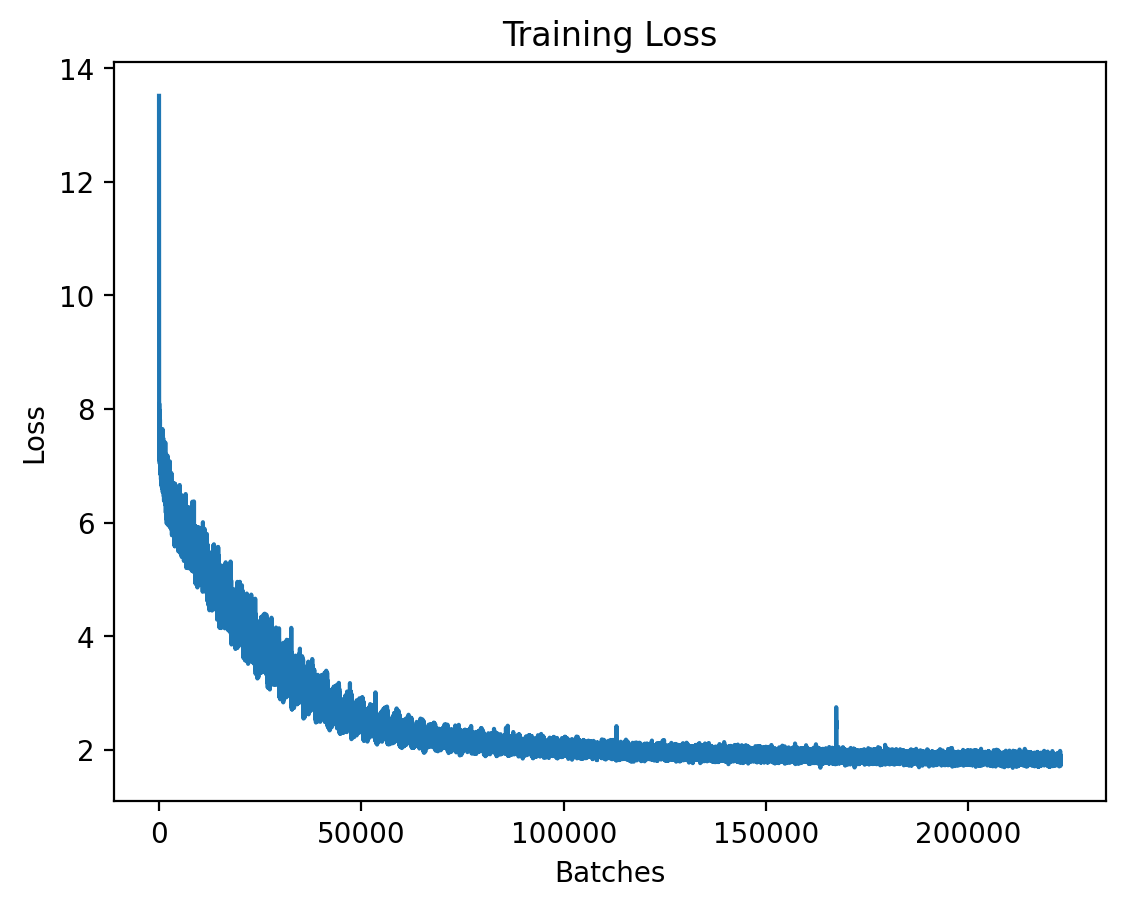

In [19]:
#plot losses
import matplotlib.pyplot as plt

plt.plot(losses)

plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.show()
